# PART 1

## Unix Tail function but in python implementation

In [1]:
import time


def follow(file):
    file.seek(0, 2)
    while True:
        line = file.readline()
        if not line:
            time.sleep(0.1)
            continue
        yield line


def main():
    with open('data/sample-2mb-text-file.txt') as file:
        for line in follow(file):
            print(line)

main()

KeyboardInterrupt: 

# Pipeline approach
Pipeline approach
"follow" script yields every new line added to logfile whereas grep script returns the line that contain a specific pattern


In [2]:
def grep(pattern, lines):
    for line in lines:
        if pattern in line:
            yield line

def main_grep():
    with open("data/sample-2mb-text-file.txt") as logfile:
        loglines = follow(logfile)
        matched_lines = grep("test", loglines)
        for line in matched_lines:
            print(line)

main_grep()

In [6]:
def grep_coroutine(pattern):
    print("Looking for pattern")
    while True:
        line = (yield)  # here we receive the value from send method
        if pattern in line:
            print(line)
            
def main_grep_coroutine():
    g = grep_coroutine("test")
    # we need to prime the coroutine
    g.send(None)
    g.send("It is good but bad, BUUUT amazing")
    g.send("Still amazing but test")

main_grep_coroutine()

Looking for pattern
Still amazing but test


# Coroutine decorator

In [19]:
def coroutine(func):
    def start(*args, **kwargs):
        cr = func(*args, **kwargs)
        cr.send(None) # coroutine priming
        return cr
    return start

In [10]:
@coroutine
def grep(pattern):
    while True:
        line = (yield)
        if pattern in line:
            print(line)

In [11]:
g = grep(pattern="test")
g.send("Hello test")
g.send("test")

# close a coroutine
g.close()

Hello test
test


### Catching close() with try catch

In [14]:
@coroutine
def grep(pattern):
    try:
        while True:
            line = (yield)
            if pattern in line:
                print("---", line)
    except GeneratorExit:
        print("Exit from generator")

g = grep(pattern="test")
g.send("Hello test")
g.send("test")

# close a coroutine
g.close()

--- Hello test
--- test
Exit from generator


## Do not confuse generators with coroutines
- Generators `produce data` for iteration
- Coroutines are `consumers` of data
- To keep your brain from exploding, you don't mix
  the two concepts together
- Coroutines are not related to iteration
- Note :There is a use of having yield produce a
  value in a coroutine, but it's not tied to iteration.

### Bogus example

In [21]:
def countdown(n):
    while n >= 0:
        newvalue = (yield n)
        print(n)
        if newvalue is not None:
            n = newvalue
        else:
            n -= 1
        
c = countdown(5)
for n in c:
    if n == 5:
        c.send(3)

5
3
2
1
0


# PART 2

## Pipelines

- It is represented in chain of coroutines. We push data between them with   send operator.
- Pipeline should have an initial source aka producer which is tipically not a coroutine
- Pipeline must have an end-point(sinlk)

In [4]:
def source(target):
    while not done:
        item = produce_an_item()
        ...
        target.send(item)
        ...
    target.close()


In [8]:
@coroutine
def sink():
    try:
        while True:
            item = (yield)
            ...
    except GeneratorExit:
        #exit the pipeline
        ...

## Example of pipeline

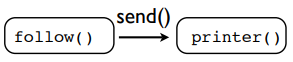

In [11]:
# source
def follow(file, target):
    file.seek(0, 2)
    while True:
        line = file.readline()
        if not line:
            time.sleep(0.1)
            continue
        target.send(line)

        
# sink
@coroutine
def printer():
    while True:
        line = (yield)
        print(line)

        
def main():
    with open('data/sample-2mb-text-file.txt') as file:
        follow(file, printer())
        
        
main()

KeyboardInterrupt: 

In [ ]:
def client():
    with open('data/sample-2mb-text-file.txt', 'w') as file:
        file.write("test")

## Pipeline filters

These are the intermediate stages that have both recieve and send
They perform some kind of data transformation, filtering, routing

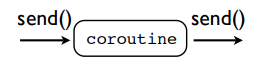

In [12]:
@coroutine
def filter(target):
    while True:
        item = (yield)
        # transform data or filter
        ...
        # send data to the next stage
        target.send(item)

## Filter example

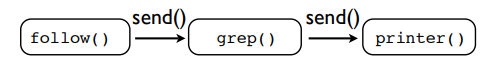

In [ ]:
# source
def follow(file, target):
    file.seek(0, 2)
    while True:
        line = file.readline()
        if not line:
            time.sleep(0.1)
            continue
        target.send(line)

# filter        
@coroutine
def grep(pattern, target):
    whoile True:
        line = (yield)
        if pattern in line:
            target.send(line)
                     
# sink
@coroutine
def printer():
    while True:
        line = (yield)
        print(line)

        
def main():
    with open('data/sample-2mb-text-file.txt') as file:
        follow(file,
               grep("test",
               printer()))
        
        
main()
            

### Thing to remember!!!
- Generators `pull` data through the pipe with iteration
- Coroutines `push` data into pipeline with send()

## Being Branchy(Broadcasting)

With coroutines we can send data to multiple destinations 

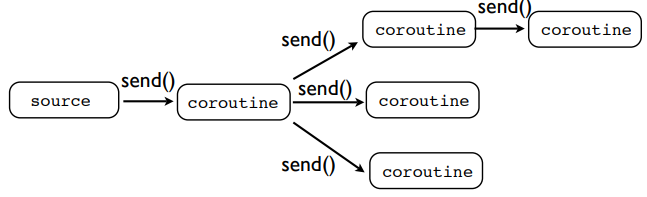

In [13]:
# here we have a sequence of coroutines(targets) 
# and sends received items to all of them
@coroutine
def broadcast(targets):
    while True:
        item = (yield)
        for target in targets:
            target.send(item)

## Example: Broadcasting

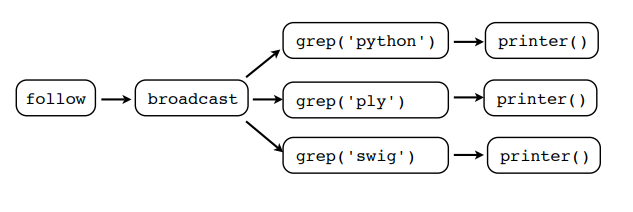

In [ ]:
# source
def follow(file, target):
    file.seek(0, 2)
    while True:
        line = file.readline()
        if not line:
            time.sleep(0.1)
            continue
        target.send(line)
        
# broadcaster
@coroutine
def broadcast(targets):
    while True:
        item = (yield)
        for target in targets:
            target.send(item)

# filter
@coroutine
def grep(pattern, target):
    while True:
        line = (yield)
        if pattern in line:
            target.send(line)
            
# sink
@coroutine
def printer():
    while True:
        line = (yield)
        print(line)
        

def main():
    with open('data/sample-2mb-text-file.txt') as file:
        f = open("access-log")
        follow(f,
               broadcast([grep('python', printer()),
                          grep('ply', printer()),
                          grep('swig', printer())])

With single printer

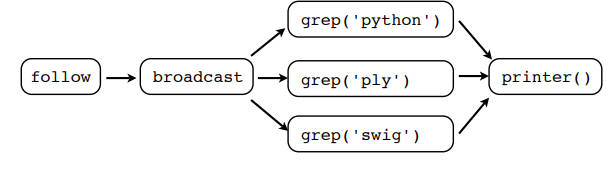

In [14]:
# with single printer() object
def main():
    with open('data/sample-2mb-text-file.txt') as file:
        f = open("access-log")
        p = printer()
        follow(f,
               broadcast([grep('python',p),
                          grep('ply',p),
                          grep('swig',p)])
               )

### Things to remember!!!
- Coroutines provide more powerful data routing 
  possibilities than simple iterators
- If you built a collection of simple data processing
  components, you can glue them together into
  complex arrangements of pipes, branches,
  merging, etc.
- Although there are some limitations (later)

## Digression

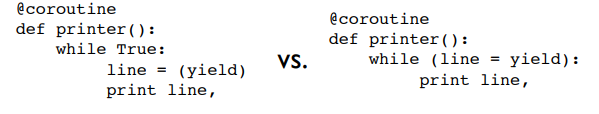

## Coroutines vs Objects

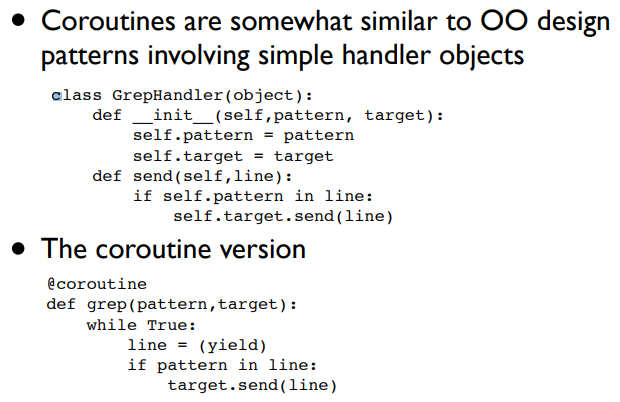

Coroutines is one function definition
Whereas if we define a handler class we need
- class definition
- two method definition
- pribably a base class and a library import

# Part 3

## Event handling

Coroutines can be used to write various components that process streams

- XML parsing could be done with SAX approach 
- SAX is an event driven interface 

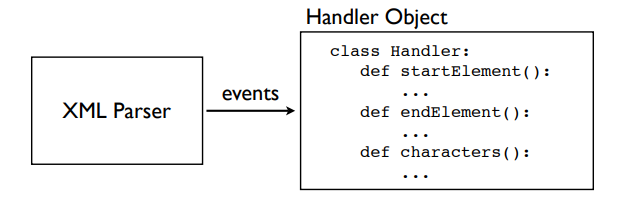

Benefits of SAX:
- memory, because we do not need to store the wholw document content unlike DOM
- speed, tasks like indexing, conversion to other formats, simple formatting could be done using SAX

Drawbacks:
- we need to store temporary information for later validations. For example, to validate that all the elements in the document uses the same id value we need to keep track of all id attributes when parsing the document
- we cannot access any node at any time because we does not store the XML document in the memory and every time we need to parse the document again to retrieve the desired field

### Classical example

In [17]:
import xml.sax


class MyHandler(xml.sax.ContentHandler):
    def startElement(self, name, attrs):
        print("startElement", name)

    def endElement(self, name):
        print("endElement", name)

    def characters(self, text):
        print("characters", repr(text)[:40])

        
xml.sax.parse("data/bus.xml", MyHandler())        

startElement buses
characters '\n'
characters ' '
startElement bus
characters '\n'
characters ' '
startElement id
characters '7574'
endElement id
characters '\n'
characters ' '
startElement route
characters '\n'
characters '  '
startElement morning
characters '123'
endElement morning
characters '\n'
characters '  '
startElement evening
characters '321'
endElement evening
characters '\n'
characters ' '
endElement route
characters '\n'
characters ' '
startElement color
characters '#3300ff'
endElement color
characters '\n'
characters ' '
startElement revenue
characters 'true'
endElement revenue
characters '\n'
characters ' '
startElement direction
characters 'North Bound'
endElement direction
characters '\n'
characters ' '
startElement latitude
characters '41.925682067871094'
endElement latitude
characters '\n'
characters ' '
startElement longitude
characters '-87.63092803955078'
endElement longitude
characters '\n'
characters ' '
startElement pattern
characters '2499'
endElement pattern


### Coroutines approach

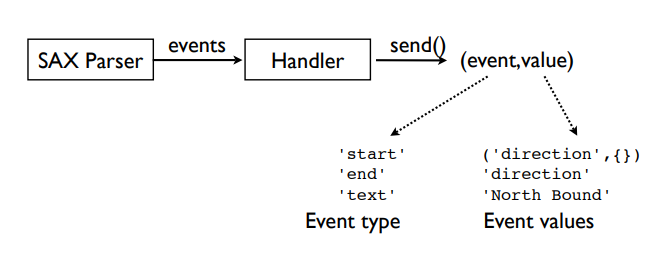

In [104]:
# SOURCE
import xml.sax


class MyHandler(xml.sax.ContentHandler):
    def __init__(self, target):
        self.target = target
    
    def startElement(self, name, attrs):
        self.target.send(("start", (name, attrs._attrs)))
        
    def endElement(self, name):
        self.target.send(("end", name))

    def characters(self, text):
        self.target.send(("text", text))
        

In [128]:
# SOURCE
import xml.parsers.expat

def expat_parse(path, target):
    with open(path, 'rb') as file:
        parser = xml.parsers.expat.ParserCreate()
        parser.buffer_size = 65536
        parser.buffer_text = True
        parser.StartElementHandler = \
            lambda name,attrs: target.send(('start',(name,attrs)))
        parser.EndElementHandler = \
            lambda name: target.send(('end',name))
        parser.CharacterDataHandler = \
            lambda data: target.send(('text',data))

        parser.ParseFile(file)

It is better to represent XML as a dictionary

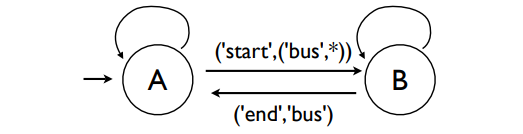

In [105]:
@coroutine
def bus_to_dict(target):
    # A
    while True:
        event, value = (yield)
        if event == "start" and value[0] == "bus":
            busdict = {}
            fragments = []
            
            # B
            while True:
                event, value = (yield)
                if event == "start": fragments = []
                elif event == "text": 
                    fragments.append(value)
                elif event == "end": 
                    if value != "bus":
                        busdict[value] = "".join(fragments)
                    else:
                        target.send(busdict)
                        break
            

Add some filtering

In [106]:
@coroutine
def filter_on_field(fieldname, value, target):
    while True:
        busdict= (yield)
        if busdict[fieldname] == value:
            target.send(busdict)

Get locations of the buses (SINK)

In [107]:
@coroutine
def bus_locations():
    while True:
        bus = (yield)
        print(f'{bus["route"]},\"{bus["direction"]}\",{bus["latitude"]},{bus["longitude"]}')

In [140]:
#%%timeit SLOWER 400
xml.sax.parse("data/bus.xml",
    MyHandler(
    bus_to_dict(
    filter_on_field("route","22", 
    bus_locations())))
    )

22,"North Bound",41.925682067871094,-87.63092803955078
22,"South Bound",22.925682067871094,-34.63092803955078


In [141]:
#%%timeit FASTER 200
expat_parse("data/bus.xml",
    bus_to_dict(
    filter_on_field("route","22", 
    bus_locations())))

22,"North Bound",41.925682067871094,-87.63092803955078
22,"South Bound",22.925682067871094,-34.63092803955078


### Things to remember!!!
- Expat SAX is faster because expat is low-level C-extension module

# Part 4
## From Data Processing to Concurrent Programming


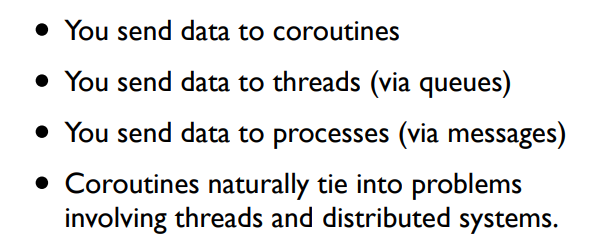

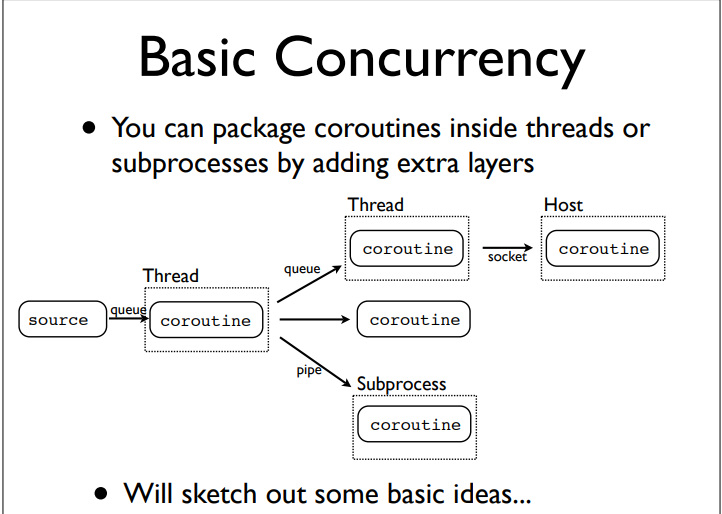

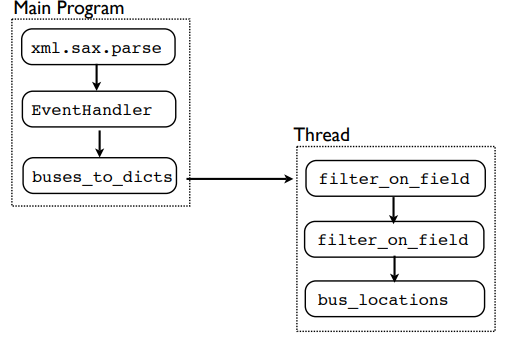

In [4]:
from queue import Queue
from threading import Thread


messages = Queue()



@coroutine 
def threaded(target):
        """
        1. initialize message queue
        2. run the Thread with the function that
           - pulls the elements from the queue and sens it to the target
             coroutine
           - on generator exit it closes the target coroutine
        3. populate the queue untill the GeneratorExit is sent
        """
        Thread(target=run_target, args=(target,)).start()
        try:
            while True:
                item = (yield)
                messages.put(item)
        except GeneratorExit:
            messages.put(GeneratorExit)

def run_target(target):
    while True:
        item = messages.get()
        if item is GeneratorExit:
            target.close()
            return
        else:
            target.send(item)
        

NameError: name 'coroutine' is not defined

In [176]:
xml.sax.parse("data/bus.xml", MyHandler(
        bus_to_dict(
        threaded(
        filter_on_field("route","22",
        filter_on_field("direction","North Bound",
        bus_locations()))
        ))))

22,"North Bound",41.925682067871094,-87.63092803955078


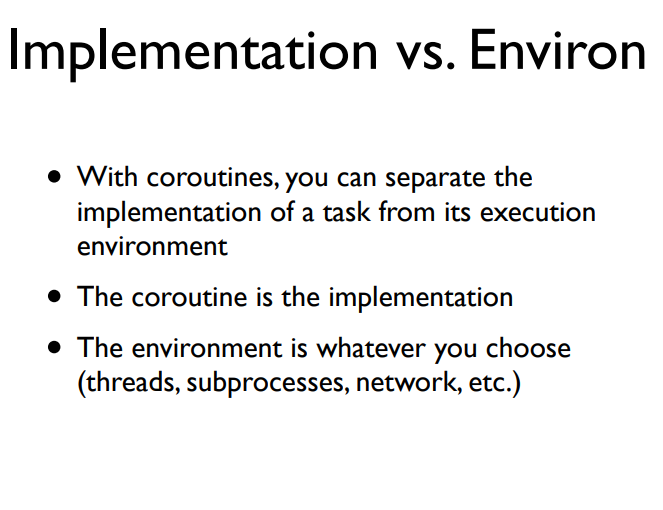

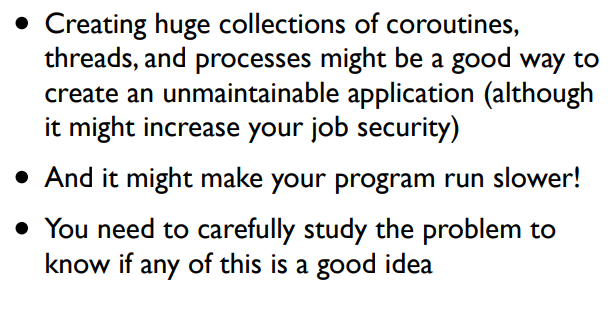

- send method is not thread safe
- if we mix coroutines and threads we can crash the program 
- if calling send() on already-executing coroutine, the program will crash
- Example: Multiple threads sending data into the same target coroutine 

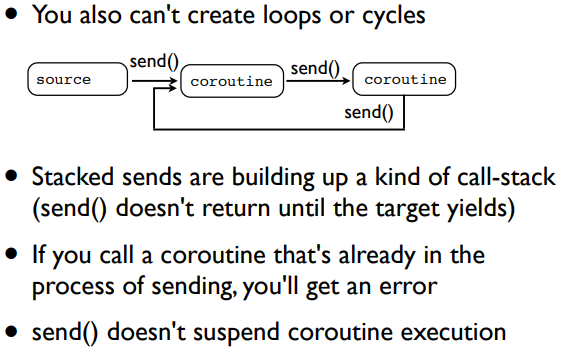

# Part 5
## Coroutines as Tasks

### Tasks have a few essential features
- independent control flow
- Internal state
- Can be scheduled(suspended/resumed)
- can communicate with other tasks

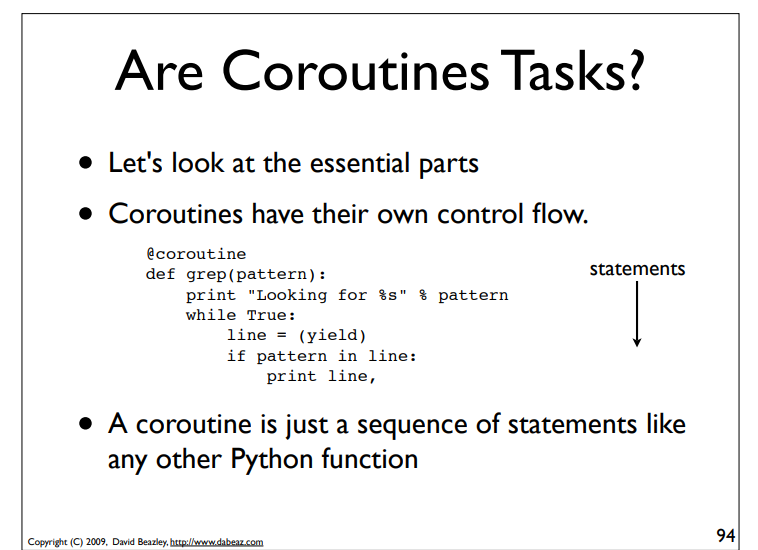

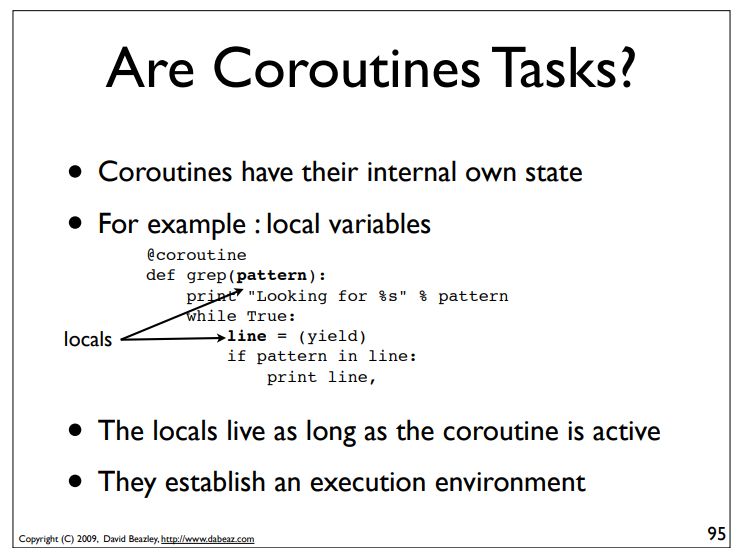

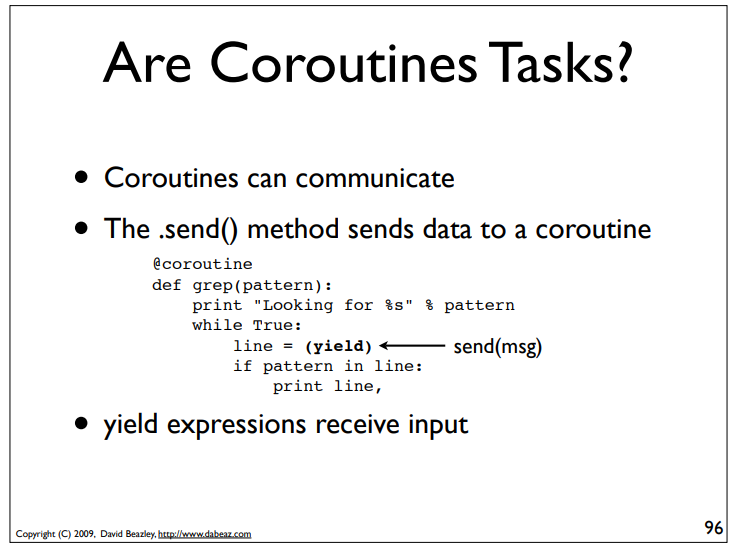

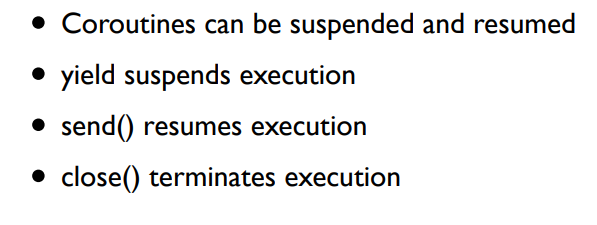

# Part 6

## Crash course in operating systems

- CPU dont know anything about multitasking
- Nor do application programs
- All the work is done by the operating system 

### Operating system 
- Operating system does allow more than one process to execute at once
- It does this by rapidly switching between tasks

### Conundrum
- When CPU is running the program, it is not runnign the operating system
- There are two mechanisms that an operating system uses to gain control 
- Interrupts = hardware sygnal(data receiver, timer, keypress)
- Trap = a software generated sygnal 

- In both cases the CPU briefly suspends what it is doing and runs code thats part of the OS
- It is at this time the OS might switch tasks

### Traps and system calls 
- Low level system calls are actually traps
- It is special CPU instruction

For example let's see how the read operations works under the hood
- `read(fb, buf, nbytes)`
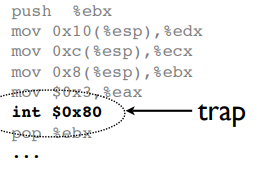

When the `int` command executes, the program suspends execution at that point and the OS takes over 

This is done because to read a file the operating system should look for the file in the disc and reeturn data to the program to read the file

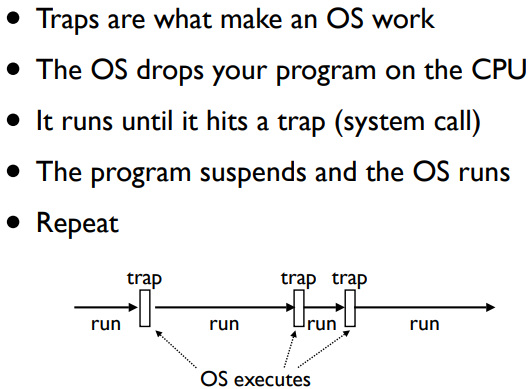

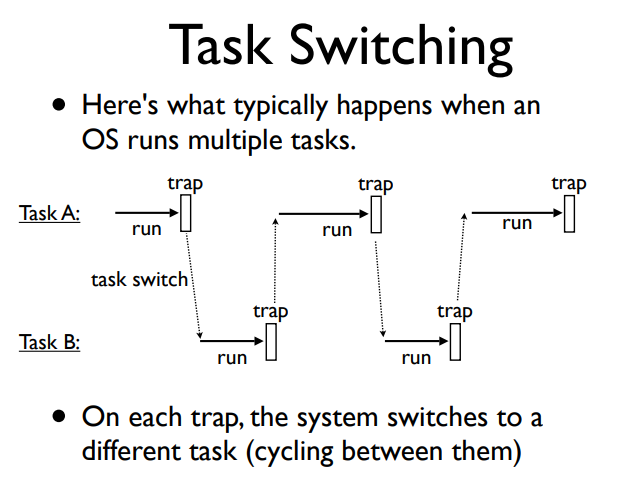

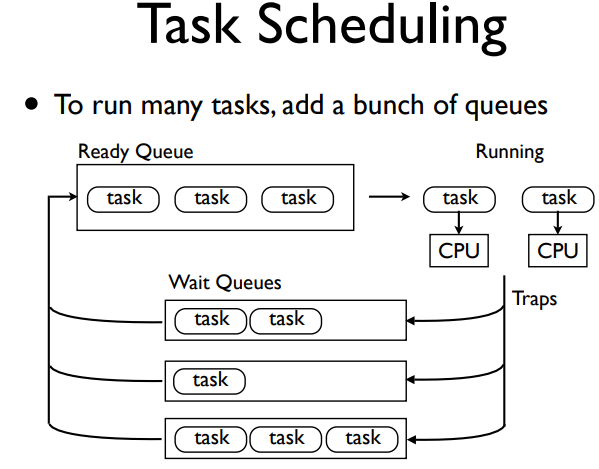

# Part 7

## Build an Operating System

### Step 1: Task object

In [6]:
# Task is a wrapper around coroutine
class Task:
    taskid = 0
    def __init__(self, target):
        Task.taskid += 1
        self.tid = Task.taskid # task id
        self.target = target   # target coroutine
        self.sendval = None    # value to send
    
    # run a task untill it hits the next yield statement
    def run(self):
        return self.target.send(self.sendval)

In [6]:
# Example 
def test():
    print("Part 1")
    yield
    print("Part 2")
    yield

t1 = Task(test())
print("running test()")
t1.run()
print("resuming test()")
t1.run()

running test()
Part 1
resuming test()
Part 2


### Step 2: The scheduler

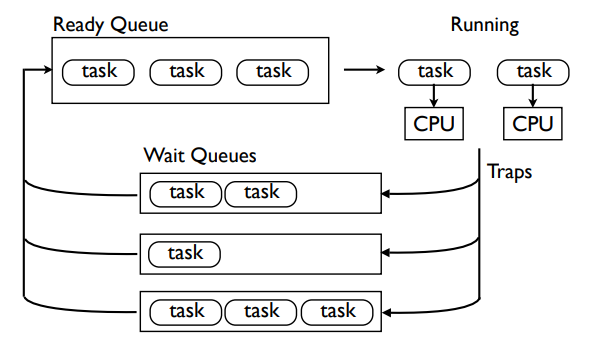

In [20]:
from queue import Queue

class Scheduler:
    def __init__(self):
        self.ready = Queue() # a queue of tasks that are ready to run
        self.taskmap = {}
    
    # introduces a new task to the scheduler
    def new(self, target):
        newtask = Task(target)
        self.taskmap[newtask.tid] = newtask
        self.schedule(newtask)
        return newtask.tid
    
    def exit(self, task):
        print(f"Task {task} terminated")
        del self.taskmap[task.tid]
    
    #puts a task on the ready queue
    def schedule(self, task):
        self.ready.put(task)
        
    def mainloop(self):
        while self.taskmap:
            task = self.ready.get()
            try:
                result = task.run()
            except StopIteration:
                self.exit(task)
                continue
            self.schedule(task)
    

In [23]:
# define two tasks

def foo_loop():
    for i in range(10):
        print("FOO")
        yield

def foo():
    while True:
        print("FOO")
        yield

def bar():
    while True:
        print("BAR")
        yield
        

scheduler = Scheduler()
scheduler.new(foo_loop())
scheduler.new(bar())
scheduler.mainloop()

FOO
BAR
FOO
BAR
FOO
BAR
FOO
BAR
FOO
BAR
FOO
BAR
FOO
BAR
FOO
BAR
FOO
BAR
FOO
BAR
Task <__main__.Task object at 0x000002A91F2C6640> terminated
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR

BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR


BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR


BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR


BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR


BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR


BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR
BAR


KeyboardInterrupt: 

### Step 3: Task Exit

In [ ]:
def exit(self, task):
    print(f"Task {task} terminated")
    del self.taskmap[task.tid]
    
    
def mainloop(self):
        while self.taskmap:
            task = self.ready.get()
            try:
                result = task.run()
            except StopIteration:
                self.exit(task)
                continue
            self.schedule(task)

### Step 4: System calls

- System calls are how application programs request the service of the operating system
- The Scheduler is the operating system and the yield statement is a trap
- To request the service of the scheduler, tasks will use the yield statement with the value 

In [3]:
# Task is a wrapper around coroutine
class Task:
    taskid = 0
    def __init__(self, target):
        Task.taskid += 1
        self.tid = Task.taskid # task id
        self.target = target   # target coroutine
        self.sendval = None    # value to send
    
    # run a task untill it hits the next yield statement
    def run(self):
        return self.target.send(self.sendval)

In [2]:
from queue import Queue

#Base class for SystemCall
class SystemCall:
    def handle(self):
        pass

class GetTid(SystemCall):
    def handle(self):
        self.task.sendval = self.task.tid
        self.sched.schedule(self.task)
    
    
    
class Scheduler:
    def __init__(self):
        self.ready = Queue() # a queue of tasks that are ready to run
        self.taskmap = {}
    
    # introduces a new task to the scheduler
    def new(self, target):
        newtask = Task(target)
        self.taskmap[newtask.tid] = newtask
        self.schedule(newtask)
        return newtask.tid
    
    #delet the task from map if we face stop iteration exception
    def exit(self, task):
        print(f"Task {task.tid} terminated")
        del self.taskmap[task.tid]
    
    #puts a task on the ready queue
    def schedule(self, task):
        self.ready.put(task)
        
    def mainloop(self):
        while self.taskmap:
            task = self.ready.get()
            try:
                result = task.run()
                if isinstance(result, SystemCall):
                    result.task = task
                    result.sched = self
                    result.handle()
                    continue
            except StopIteration:
                self.exit(task)
                continue
            self.schedule(task)

In [9]:
def foo():
    mytid = yield GetTid() # creates a GetTid object
    for _ in range(5):
        print(f"FOO {mytid}")
        yield

def bar():
    mytid = yield GetTid()
    for _ in range(10):
        print(f"BAR {mytid}")
        yield
        
sched = Scheduler()
sched.new(foo())
sched.new(bar())
sched.mainloop()

FOO 5
BAR 6
FOO 5
BAR 6
FOO 5
BAR 6
FOO 5
BAR 6
FOO 5
BAR 6
Task 5 terminated
BAR 6
BAR 6
BAR 6
BAR 6
BAR 6
Task 6 terminated


### Design improvements
- Real operating systems have strong notion of protectio
- Application programms are not strongly linked to the OS kernel 
- We need to emulate:
-  `Tasks should not see the scheduler`
-  `Tasks should not see other tasks`
-  `yield is the only external interface`

### Step 5: Task Management
- Task management functions:
- `create a new task`
- `kill an existing task`
- `wait for a task to exit`

Create a new task

In [10]:
class NewTask(SystemCall):
    def __init__(self, target):
        self.target = target
        
    def handle(self):
        tid = self.sched.new(self.target)
        self.task.sendval = tid
        self.sched.schedule(self.task)

Kill a task

In [11]:
class KillTask(SystemCall):
    def __init__(self, tid):
        self.tid = tid
    
    def handle(self):
        task = self.sched.taskmap.get(self.tid, None)
        if task:
            task.target.close()
            self.task.sendval = True
        else:
            self.task.sendval = False
        self.sched.schedule(self.task)

Wait for task

In [12]:
class WaitTask(SystemCall):
    def __init__(self, tid):
        self.tid = tid
    
    def handle(self):
        result = self.sched.wait_for_exit(self.task, self.tid)
        self.task.sendval = result
        # if we wait for non-existent task we should return the result immideately
        if not result:
            self.sched.schedule(self.task)


In [13]:
class Scheduler:
    def __init__(self):
        self.ready = Queue() # a queue of tasks that are ready to run
        self.taskmap = {}
        self.exit_waiting = {}
    
    # introduces a new task to the scheduler
    def new(self, target):
        newtask = Task(target)
        self.taskmap[newtask.tid] = newtask
        self.schedule(newtask)
        return newtask.tid
    
    #delet the task from map if we face stop iteration exception
    def exit(self, task):
        print(f"Task {task.tid} terminated")
        del self.taskmap[task.tid]
        # we need to notify other tasks waiting for exit
        for task in self.exit_waiting.pop(task.tid, []):
            self.schedule(task)
    
    def wait_for_exit(self, task, waitid):
        if waitid in self.taskmap:
            self.exit_waiting.setdefault(waitid, []).append(task)
            return True
        else:
            return False
    
    #puts a task on the ready queue
    def schedule(self, task):
        self.ready.put(task)
        
    def mainloop(self):
        while self.taskmap:
            task = self.ready.get()
            try:
                result = task.run()
                if isinstance(result, SystemCall):
                    result.task = task
                    result.sched = self
                    result.handle()
                    continue
            except StopIteration:
                self.exit(task)
                continue
            self.schedule(task)

In [14]:
def foo():
    for _ in range(5):
        print("I am foo")
        yield

def main():
    child = yield NewTask(foo())
    print("Waiting for child")
    yield WaitTask(child)
    print("Child done")


sched = Scheduler()
sched.new(main())
sched.mainloop()

I am foo
Waiting for child
I am foo
I am foo
I am foo
I am foo
Task 3 terminated
Child done
Task 2 terminated


###  Things to remember!
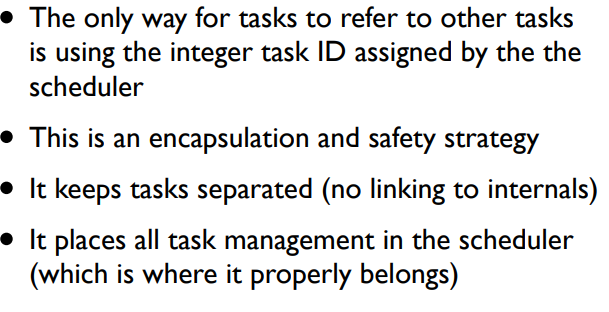

### Non-blocking I/O
Select module can be used to monitor a collection of sockets for activity. We can use it to add I/O support to pur OS and it will be somehow similar to the task waiting
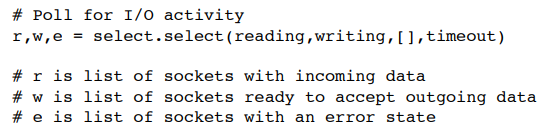

File descripytor is a number that identifies an open file in the system 
- The descriptor is identified by a unique non-negative integer such as 0, 12, 567
- Once a process makes a successful request to open a file, the kernel returns a file descriptor
- On Unix-like system, the first three file descriptors are `STDIN`, `STDOUT`, `STDERR`

### See scheduler.py

### Polling

There are three concepts:

Suppose you are in a car
- **Busy wait**
<br>
If you have a staring contest with the traffic light and you are doing nothing but waiting for the green light, you are doing a busy wait


- **Polling**
<br>
If you are texting your girlfriend/boyfriend and looking up every 10 seconds, you are polling with a frequency of 10 seconds.


- **Interruption**
<br>
If you are texting your girlfriend/boyfriend until the car behind you honks and mentions your mother, you are using interrupts.

With polling we can poll a socket for every few millisecond to see if a new message arrived

# Part 8
## The proble with Stack

### Limitations
When working with coroutines, you can't write functions that yield(suspend)

In [1]:
def Accept(sock):
    yield ReadWait(sock)
    return sock.accept()

def server(port):
    ...
    while True:
        client, address = Accept(sock)
        yield NewTask(handle_client(client, addre))

The yield could only suspend coroutine when used ath the `top-most level`

SOLUTION:
- The subrotine calls are only possible with the assistence of the task scheduler itself
- We have to strict;y stick to yield statements
- Use a trick called "trampolining"

### Coroutine Trampolining

In [10]:
def add(x, y):
    yield x + y
    
def main():
    r = yield add(2,2)
    print(r)
    yield
    
def scheduler():
    m = main()
    sub = m.send(None)
    result = sub.send(None)
    m.send(result)

scheduler()

4


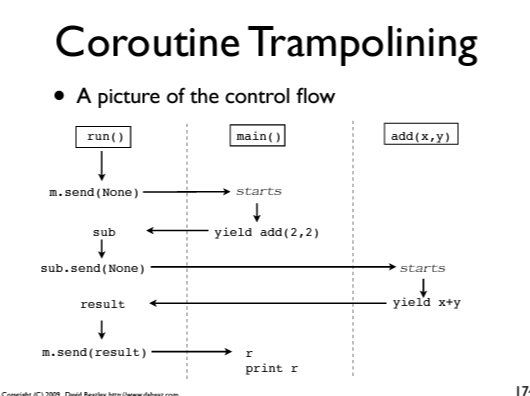

### SUM UP
Generators are much powerful
- Customized iteration patterns
- Processing pipelines and data flow
- Event handling
- Cooperative multitasking

### When using coroutines it is important to not mix programming paradigms together 

3 main uses of yield:
- Iteration(producer of data)
- Receiving messages(a consumer)
- A trap
DO NOT write generator functions that try to do more than one of these roles